In [42]:
## Import libraries
import os
import argparse
import json
import cv2
import numpy as np
import pandas as pd
from copy import deepcopy
from sklearn.utils import shuffle
from keras.models import Sequential, model_from_json
from keras.layers import Dense, Dropout, Flatten, Lambda, ELU, MaxPooling2D
from keras.regularizers import l2, activity_l2
from keras.layers.convolutional import Convolution2D
from keras.layers.core import Activation, Reshape
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

# data paths
training_data = '../P3Training/driving_log.csv'
udacity_data = 'data/driving_log.csv'
udacity_path_prefix = 'data/'
training_path_prefix='../P3Training/IMG/'


In [43]:
#Gather left  right and center images also
f = open(training_data)
images=[]
measurements=[]
correction=0.15
for line in f:
    tokens=line.split(',')
    for i in range(3):
        
        nameToken=tokens[i]
        name=nameToken.split('/')[-1]
        
        imageName=training_path_prefix+name
        image=plt.imread(imageName)
        images.append(image)
    steeringAngle=(float)(tokens[3])
    measurements.append(steeringAngle)
    measurements.append(steeringAngle+correction)
    measurements.append(steeringAngle-correction)
            
        
    '''image=plt.imread(tokens[0])
    plt.imshow(image)
    images.append(image)
    measurements.append(tokens[3])'''
print(len(images))
print(len(measurements))




11889
11889


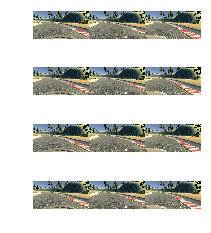

In [3]:
fig, axs = plt.subplots(4,3, figsize=(3, 4))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()


for i, img in enumerate(images[0:12]):
    axs[i].axis('off')
    axs[i].imshow(img)

In [44]:
# Image cropping delimiters
HORIZON=60
BONNET=136

def crop(image):
    """
    Crop the image between the given delimiters for the
    horizon and the bonnet of the car.
    """
    shape = image.shape
    
    cropped = image[HORIZON:BONNET,0:shape[1],:]
    
    return cropped

def resize(image, resize_dim):
    return cv2.resize(image,resize_dim,cv2.INTER_AREA)

In [45]:
#flip the images
augmented_images=[]
augmented_measurements=[]
for image,measurement in zip(images,measurements):
    flippedImage=cv2.flip(image,1)
    flippedMeasurement=measurement*-1.0
    flippedImage=crop(flippedImage)
    flippedImage=resize(flippedImage,(64,64))
    augmented_images.append(flippedImage)
    augmented_measurements.append(flippedMeasurement)
    
    image=crop(image)
    image=resize(image,(64,64))
    
    augmented_images.append(image)
    augmented_measurements.append(measurement)
    
    
print(len(augmented_images))
print(len(augmented_measurements))
print (augmented_images[0].shape)


23778
23778
(64, 64, 3)


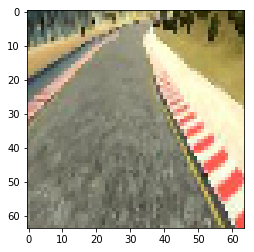

In [6]:
plt.imshow(augmented_images[500])

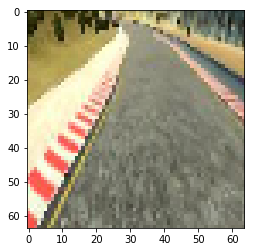

In [7]:
plt.imshow(augmented_images[501])

In [46]:
X_train=np.array(augmented_images)
y_train=np.array(augmented_measurements)



In [47]:
print(X_train.shape)
print(y_train.shape)

(23778, 64, 64, 3)
(23778,)


In [48]:
from keras.optimizers import Adam



# Training parameters
learning_rate = 1e-4
number_of_epochs = 7
batch_size = 64
number_of_samples_per_epoch = 20032
validation_split = 0.3

# Images size
resize_x=64
resize_y=64

# Input layer shape
ch, row, col = 3, resize_x, resize_y

# Model definition taken from Nvidia's paper at:
# http://images.nvidia.com/content/tegra/automotive/images/2016/solutions/pdf/end-to-end-dl-using-px.pdf
def nv():
    model = Sequential()
    
    model.add(Lambda(lambda x: x/127.5 - 1.,
            input_shape=(col,row,ch),
            output_shape=(col,row,ch)))
    
    model.add(Convolution2D(24, 5, 5, subsample=(2, 2), border_mode="same"))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))
    
    model.add(Convolution2D(36, 5, 5, subsample=(2, 2), border_mode="same"))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))

    model.add(Convolution2D(48, 5, 5, subsample=(2, 2), border_mode="same"))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))

    model.add(Convolution2D(64, 3, 3, border_mode="same"))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))

    model.add(Convolution2D(64, 3, 3, border_mode="same"))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))
    
    model.add(Flatten())
    model.add(Dropout(.2))
    model.add(Activation('relu'))
    model.add(Dense(1164))
    model.add(Dropout(.5))
    model.add(Activation('relu'))
    model.add(Dense(100))
    model.add(Dropout(.5))
    model.add(Activation('relu'))
    model.add(Dense(50))
    model.add(Dropout(.5))
    model.add(Activation('relu'))
    model.add(Dense(10))
    model.add(Dropout(.5))
    model.add(Activation('relu'))
    model.add(Dense(1))
    return model

# construct the selected model and print it out
model = nv()
model.summary()
model.compile(loss='mean_squared_error', optimizer=Adam(lr=learning_rate))


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_4 (Lambda)                (None, 64, 64, 3)     0           lambda_input_4[0][0]             
____________________________________________________________________________________________________
convolution2d_16 (Convolution2D) (None, 32, 32, 24)    1824        lambda_4[0][0]                   
____________________________________________________________________________________________________
activation_31 (Activation)       (None, 32, 32, 24)    0           convolution2d_16[0][0]           
____________________________________________________________________________________________________
maxpooling2d_16 (MaxPooling2D)   (None, 31, 31, 24)    0           activation_31[0][0]              
___________________________________________________________________________________________

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import scipy.misc
import random
import os
from scipy.ndimage import rotate
from scipy.stats import bernoulli

# CSV column names
COLUMNS = ['center','left','right','steering','throttle','brake','speed']


# Parameters to calculate the steering correction when taking left/right cameras
# https://medium.com/@ksakmann/behavioral-cloning-make-a-car-drive-like-yourself-dc6021152713#.fc0drgwk7
offset=1.0
dist=15.0
STEERING_COEFFICIENT = offset/dist * 360/( 2*np.pi)  / 25.0

def random_flip(image, steering_angle, flipping_prob=0.5):
    """
    Randomly flip an image, with a given probability
    """
    if random.random() < flipping_prob:
        return np.fliplr(image), -1 * steering_angle
    else:
        return image, steering_angle

def random_shadows(image):
    """
    Generate a random shadow on the image
    area parameter is a percentage of the total image area
    """
    # Generate a separate buffer
    shadows = image.copy()

    image_area = shadows.shape[0] * shadows.shape[1]
    poly = get_shadow_poly(shadows.shape[0], shadows.shape[1])
    cv2.fillPoly(shadows, np.array([poly]), -1)

    alpha = np.random.uniform(0.6, 0.9)
    return cv2.addWeighted(shadows, alpha, image, 1-alpha,0,image)

def get_shadow_poly(max_x, max_y):
    """
    Get the polygons of a random area delimited between
    max_x, max_y. The polygons generated will either be horizontal
    or vertically aligned with the image, with a random distribution.
    """
    horizontal = np.random.uniform()

    if horizontal < 0.5:
        x1 = random.randint(0, max_x/2)
        y1 = 0
        x2 = random.randint(max_x / 2, max_x)
        y2 = 0
        x3 = random.randint(max_x / 2, max_x)
        y3 = max_y       
        x4 = random.randint(0, max_x/2)
        y4 = max_y
    else:
        x1 = 0
        y1 = random.randint(0, max_y/2)
        x2 = 0
        y2 = random.randint(max_y / 2, max_y)
        x3 = max_x
        y3 = random.randint(max_y / 2, max_y)       
        x4 = max_x
        y4 = random.randint(0, max_y/2)
    
    return [[x1,y1],[x2,y2],[x3,y3], [x4,y4]]

def random_shear(image, steering_angle, shear_range=200):
    """
    Sources: 
    https://medium.com/@ksakmann/behavioral-cloning-make-a-car-drive-like-yourself-dc6021152713#.7k8vfppvk
    https://github.com/ksakmann/CarND-BehavioralCloning/blob/master/model.py
    :param image:
        Source image on which the shear operation will be applied
    :param steering_angle:
        The steering angle of the image
    :param shear_range:
        Random shear between [-shear_range, shear_range + 1] will be applied
    :return:
        The image generated by applying random shear on the source image
    """
    rows, cols, ch = image.shape
    dx = np.random.randint(-shear_range, shear_range + 1)
    random_point = [cols / 2 + dx, rows / 2]
    pts1 = np.float32([[0, rows], [cols, rows], [cols / 2, rows / 2]])
    pts2 = np.float32([[0, rows], [cols, rows], random_point])
    dsteering = dx / (rows / 2) * 360 / (2 * np.pi * 25.0) / 6.0
    M = cv2.getAffineTransform(pts1, pts2)
    image = cv2.warpAffine(image, M, (cols, rows), borderMode=1)
    steering_angle += dsteering

    return image, steering_angle



def random_brightness(image, median=0.8, dev=0.4):
    """
    Source: http://stackoverflow.com/questions/32609098/how-to-fast-change-image-brightness-with-python-opencv
    :param image: the image to enhance.
    :return: the input image with altered brightness
    """
    hsv = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    random_bright = median + dev * np.random.uniform(-1.0, 1.0)
    hsv[:,:,2] = hsv[:,:,2]*random_bright

    rgb = cv2.cvtColor(hsv,cv2.COLOR_HSV2RGB)
    return rgb

def generate_new_image(image, steering_angle, resize_dim, do_shear_prob=0.5):
    """
    :param image: the image to augment.
    :param steering_angle: the steering label for this image, will be adjusted accordingly to the augmentation steps taken
    :param do_shear_prob: the probability of performing a random shear transformation on the image
    :return: the augmented image and steering angle
    """

    if random.random() < do_shear_prob:
        image, steering_angle = random_shear(image, steering_angle)

    # image = crop(image)
    # image = resize(image, resize_dim)
    # image = random_shadows(image)

    # image, steering_angle = random_flip(image, steering_angle)

    # image = random_brightness(image)

    return image, steering_angle

# center,left,right,steering,throttle,brake,speed
def get_random_camera_data(csv, index):
    """
    Get one of the left, center or right images together with
    the corresponding(adjusted) steering angle.
    """
    rnd = np.random.randint(0, 3)
    img = csv.iloc[index][COLUMNS.index('center') + rnd].strip()
    angle = csv.iloc[index][COLUMNS.index('steering')]
    
    # Adjust steering based on camera position
    if rnd == COLUMNS.index('left'):
        angle = angle + STEERING_COEFFICIENT
    elif rnd == COLUMNS.index('right'):
        angle = angle - STEERING_COEFFICIENT

    return (img, angle)

def next_batch(samples, batch_size=64):
    """
    Get a random batch of data rows
    """
    random_rows = np.random.randint(0, len(samples), batch_size)
    
    batch = []
    for index in random_rows:
        data = get_random_camera_data(samples, index)
        batch.append(data)

    return batch

def generate_next_batch(samples, resize_dim=(64,64), batch_size=64, augment=True):
    """
    Generator for image, steering angle batches.
    :param samples: set of training samples, as read from the .csv files
    :param resize_dim: images will be resized to these dimensions
    :param batch_size: the size of the batches the generator returns.
    """
    while True:
        X_batch = []
        y_batch = []
        images = next_batch(samples, batch_size)
        for img_file, angle in images:
            image = plt.imread(img_file)
            if augment:
                image, angle = generate_new_image(image, angle, resize_dim)
            else:
                image = crop(image)
                image = resize(image, resize_dim)
            X_batch.append(image)
            y_batch.append(angle)

        yield np.array(X_batch), np.array(y_batch)


In [72]:
import sklearn
import sklearn.utils
def generateData(X_data,Y_data,batch_size=32):
    print("generator called")
    num_samples = len(X_data)
    while 1: # Loop forever so the generator never terminates
        X_data,y_data= sklearn.utils.shuffle(X_data, Y_data)
        images=[]
        angles= []
        for offset in range(0, num_samples, batch_size):
            print("offset is", offset)
            image = X_data[offset:offset+batch_size]
            print("image is",image)
            angle=  y_data[offset:offset+batch_size]
            print("angle is",angle)
            images.append(image)
            angles.append(angle)
        X_train = np.array(images)
        y_train = np.array(angles)
        yield sklearn.utils.shuffle(X_train, y_train)


    
    
    


In [50]:

print(len(X_train))
print(len(y_train))

23778
23778


In [51]:

from sklearn.model_selection import train_test_split
X_train, X_val, y_train,y_val=train_test_split(X_train,y_train,test_size=0.2)

In [54]:
print(len(X_train))
print(len(y_train))
print(len(X_val))
print(len(y_val))

19022
19022
4756
4756


In [73]:

train_generator = generateData(X_train,y_train, batch_size=32)
validation_generator= generateData(X_val,y_val, batch_size=32)


In [ ]:
model=nv()

model.compile(optimizer='adam',loss='mse')

history = model.fit_generator(train_generator,
                  samples_per_epoch=128,
                  nb_epoch=3,
                  validation_data=validation_generator,
                  nb_val_samples=len(X_val),
                  verbose=1)

model.save('mymodel.h5')

generator called
Epoch 1/3
offset is 0
image is [[[[171 152 105]
   [166 146 100]
   [151 131  85]
   ..., 
   [231 234 130]
   [223 225 123]
   [228 232 121]]

  [[190 153 101]
   [181 144  92]
   [168 132  80]
   ..., 
   [249 249 111]
   [233 227 111]
   [234 228 119]]

  [[185 136  80]
   [172 124  67]
   [165 116  60]
   ..., 
   [255 241 146]
   [235 219 122]
   [244 230 122]]

  ..., 
  [[130 146 117]
   [ 57  62  72]
   [ 60  69  36]
   ..., 
   [152 147 128]
   [142 137 118]
   [153 148 129]]

  [[ 64  69  49]
   [ 49  48  71]
   [100 101  45]
   ..., 
   [138 133 114]
   [149 144 125]
   [168 163 144]]

  [[ 67  51  49]
   [ 75  66  60]
   [183 166 100]
   ..., 
   [153 148 129]
   [167 162 143]
   [147 142 123]]]


 [[[ 81  94  93]
   [ 95 112 106]
   [ 31  48  56]
   ..., 
   [143 124  89]
   [143 123  89]
   [137 118  83]]

  [[ 90 104  90]
   [114 130 117]
   [ 26  40  52]
   ..., 
   [ 96  79  53]
   [ 78  61  35]
   [ 81  65  38]]

  [[106 121  95]
   [145 162 142]
   [